## YouTube Trending Project
* ### Machine Learning Models

### Table of Contents:
* 1.Exploratory Data Analysis
* 2.Data Cleaning
* 3.Modeling
    * 3.1 Predicting Likes
        * 3.1.1 Pre-processing Data
            * 3.1.1.1 Train-Test Split (80:20)
            * 3.1.1.2 Initializing Pre-processing Pipeline
        * 3.1.2 Hyperparameter Tuning (Gridsearch)
        * 3.1.3 Regressors
            * 3.1.3.1 Linear Regression
            * 3.1.3.2 Random Forest
            * 3.1.3.3 XGBoost
        * 3.1.4 Random Forest
            * 3.1.4.1 Feature Importance
        * 3.1.5 Likes Evaluation
    * 3.2 Predicting Views
        * 3.2.1 Pre-processing Data
            * 3.2.1.1 Train-Test Split (80:20)
            * 3.2.1.2 Initializing Pre-processing Pipeline
        * 3.2.2 Hyperparameter Tuning (Gridsearch)
        * 3.2.3 Regressors
            * 3.2.3.1 Linear Regression
            * 3.2.3.2 Random Forest
            * 3.2.3.3 XGBoost
        * 3.2.4 Random Forest
            * 3.2.4.1 Feature Importance
        * 3.2.5 Views Evaluation
    * 3.3 Predicting Comment Count
        * 3.3.1 Pre-processing Data
            * 3.3.1.1 Train-Test Split (80:20)
            * 3.3.1.2 Initializing Pre-processing Pipeline
        * 3.3.2 Hyperparameter Tuning (Gridsearch)
        * 3.3.3 Regressors
            * 3.3.3.1 Linear Regression
            * 3.3.3.2 Decision Trees
            * 3.3.3.3 Random Forest
        * 3.3.4 Random Forest
            * 3.1.4.1 Feature Importance

### 3. Machine Learning Models
##### Loading Data and Libraries

In [1]:
import helpers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Encoding and Data Split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Modeling
from sklearn import metrics
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Tuning
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Reading the stitched data
df = helpers.load_df("Data/Curated_US_Data.csv")

df.head()

,categoryId,likeRatio,likes_log,views_log,dislikes_log,comment_log,days_lapse,durationHr,durationMin,durationSec,titleLength,tagCount
0,25,0.876818,11.457423,15.708863,8.733755,10.990247,0.0,1,59,15,66,12
1,10,0.985548,14.211013,15.832615,9.288227,11.853311,0.0,0,2,58,42,22
2,10,0.974122,11.938376,14.220534,7.603898,9.306832,1.0,0,3,0,42,26
3,22,0.976673,13.299495,15.487011,8.859931,10.423709,2.0,0,5,55,35,0
4,10,0.984114,11.315194,13.667111,6.487684,8.402680,1.0,0,2,59,47,22


### 3.1 Predicting Likes
#### 3.1.1 Preprocessing Data
##### 3.1.1.1 Train-Test Split (80:20)
Splitting the data into train and test sets in a 80:20 ratio

In [2]:
X = df.drop(columns=['likes_log'])
y = df['likes_log']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### 3.1.1.2 Initializing Preprocessing Pipeline
Scaling numercal data and encoding categorical data

In [4]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['durationHr','durationMin','durationSec', 'categoryId'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object']).columns) + ['durationHr','durationMin','durationSec', 'categoryId']

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown = "ignore"), categorical_features)])

y

0       11.457423
1       14.211013
2       11.938376
3       13.299495
4       11.315194
          ...    
2731    12.388952
2732    10.343966
2733    13.291704
2734    10.807706
2735     8.847791
Name: likes_log, Length: 2736, dtype: float64

In [5]:
print('Numeric Features:', numeric_features)
print('Categorical Features:', categorical_features)

Numeric Features: Index(['likeRatio', 'views_log', 'dislikes_log', 'comment_log', 'days_lapse',
       'titleLength', 'tagCount'],
      dtype='object')
Categorical Features: ['durationHr', 'durationMin', 'durationSec', 'categoryId']


#### 3.1.2 Hyperparameter Tuning (Optuna)
Using bayesian hyperparameter optimization to find optimal parameters

In [6]:
# Define Objective Function to be Maximized
def rfObjective(trial):
    # Define Random Forest Parameters
    rfParams={
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
        'max_depth' : trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,15),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2,15)
    }
    
    # Establish Random Forest Regressor Pipeline
    rfPipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(
        **rfParams
    ))])
    
    for step in range(100):
        rfPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = rfPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
rfStudy = optuna.create_study(direction='maximize')
rfStudy.optimize(rfObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

rfTrial = rfStudy.best_trial

print('Number of finished trials: ', len(rfStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(rfTrial.value))
print("Best hyperparameters: {}".format(rfTrial.params))

[I 2021-01-27 19:51:38,085] A new study created in memory with name: no-name-7a73a124-58ab-4b09-a153-4e07a39676ae
[I 2021-01-27 19:51:44,818] Trial 0 finished with value: 0.9685023468575513 and parameters: {'n_estimators': 384, 'max_depth': 22, 'min_samples_leaf': 11, 'min_samples_split': 2}. Best is trial 0 with value: 0.9685023468575513.
[I 2021-01-27 19:51:48,782] Trial 1 finished with value: 0.9715086104363988 and parameters: {'n_estimators': 214, 'max_depth': 33, 'min_samples_leaf': 10, 'min_samples_split': 9}. Best is trial 1 with value: 0.9715086104363988.
[I 2021-01-27 19:51:53,017] Trial 2 finished with value: 0.9679616513627174 and parameters: {'n_estimators': 241, 'max_depth': 30, 'min_samples_leaf': 11, 'min_samples_split': 3}. Best is trial 1 with value: 0.9715086104363988.
[I 2021-01-27 19:52:02,474] Trial 3 finished with value: 0.9737850239982796 and parameters: {'n_estimators': 476, 'max_depth': 11, 'min_samples_leaf': 9, 'min_samples_split': 2}. Best is trial 3 with va

In [7]:
# Define Objective Function to be Maximized
def xgbObjective(trial):
    # Define XGBoost Parameters
    xgbParams = {
        'n_estimators' : trial.suggest_int('n_estimators', 100,500),
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'eta' : trial.suggest_uniform('eta', 0.01, 1), # learning_rate
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_int('gamma', 0, 10), # min_split_loss
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0.1, 1.0)
    }

    # Establish XGBoost Regressor Pipeline
    xgbPipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', xgb.XGBRegressor(
        **xgbParams
    ))])
    
    for step in range(100):
        xgbPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = xgbPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
xgbStudy = optuna.create_study(direction='maximize')
xgbStudy.optimize(xgbObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

xgbTrial = xgbStudy.best_trial

print('Number of finished trials: ', len(xgbStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(xgbTrial.value))
print("Best hyperparameters: {}".format(xgbTrial.params))
    

[I 2021-01-27 20:09:20,146] A new study created in memory with name: no-name-ae98df31-fce9-4ffc-96f4-5cc9652e87e4
[I 2021-01-27 20:09:24,171] Trial 0 finished with value: 0.9750988752336304 and parameters: {'n_estimators': 457, 'max_depth': 13, 'eta': 0.13162058602791765, 'subsample': 0.3043421577977443, 'colsample_bytree': 0.7885082489260122, 'gamma': 2, 'min_child_weight': 0.2445468965648363}. Best is trial 0 with value: 0.9750988752336304.
[I 2021-01-27 20:09:27,555] Trial 1 finished with value: 0.8940075028293486 and parameters: {'n_estimators': 459, 'max_depth': 20, 'eta': 0.64164085911514, 'subsample': 0.7513164241438274, 'colsample_bytree': 0.13278059634819236, 'gamma': 8, 'min_child_weight': 0.1980340832264252}. Best is trial 0 with value: 0.9750988752336304.
[I 2021-01-27 20:09:28,737] Trial 2 finished with value: 0.9303897247378866 and parameters: {'n_estimators': 225, 'max_depth': 14, 'eta': 0.2923806281044827, 'subsample': 0.8572332682145504, 'colsample_bytree': 0.130299498

#### 3.1.3 Regressors
* ##### 3.1.3.1 Linear Regression
* ##### 3.1.3.2 Random Forest
* ##### 3.1.3.3 XGBoost


LinearRegression()
Model Score: 0.930
mae:  0.30764861304915814
mse:  0.1617673139041401
rmse:  0.40220307545335865 

RandomForestRegressor(max_depth=15, n_estimators=268)
Model Score: 0.989
mae:  0.09434047880589624
mse:  0.025381546531897545
rmse:  0.15931587030769265 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9348889297527395,
             eta=0.06630804807181494, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.0663080513, max_delta_step=0, max_depth=16,
             min_child_weight=0.9754831502145662, missing=nan,
             monotone_constraints='()', n_estimators=432, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8512802473435196,
             tree_method='exact', validate_parameters=1, verbosity=None)
Model Score: 0.995
mae:  0.07159022900031066
mse:

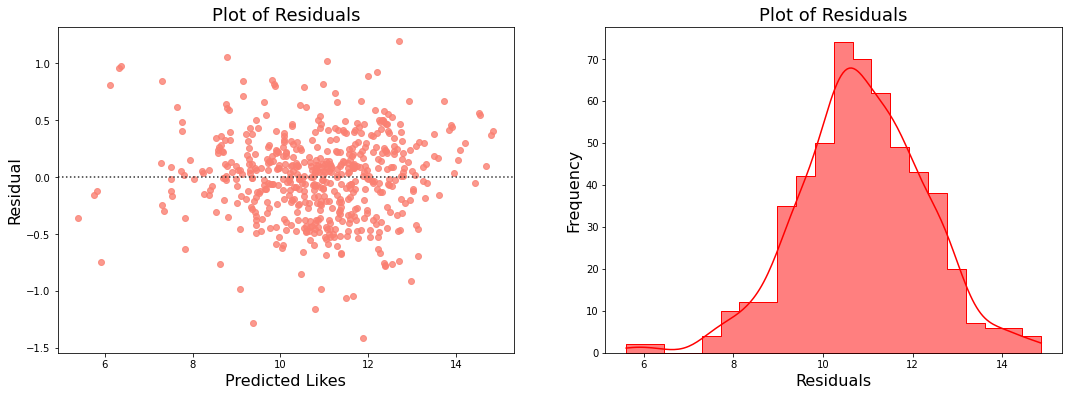

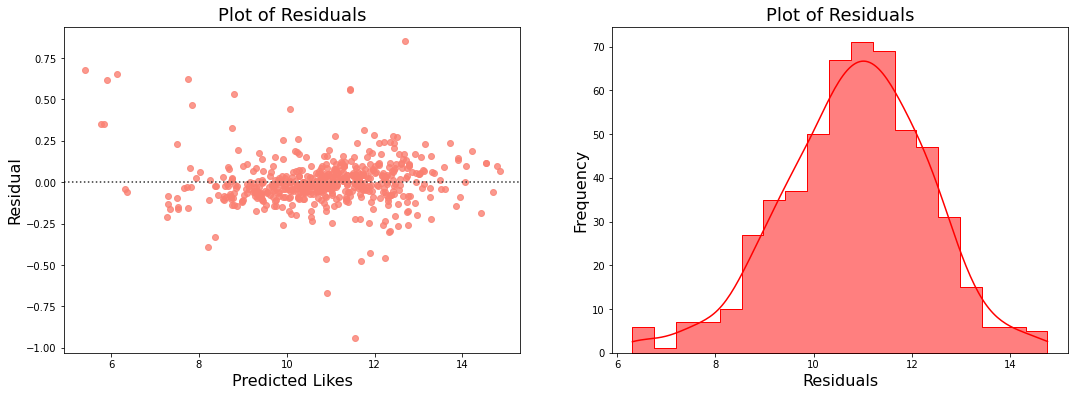

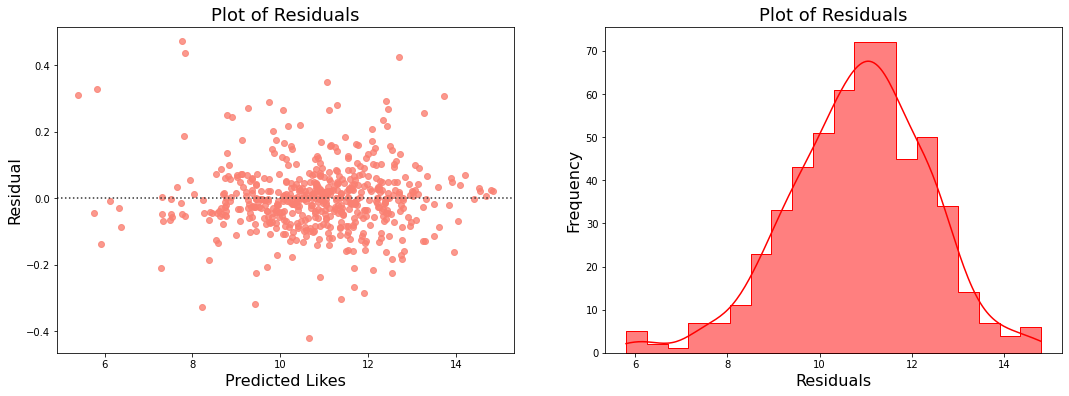

In [8]:
regressors = [
        LinearRegression(),
        RandomForestRegressor(**rfTrial.params),
        xgb.XGBRegressor(**xgbTrial.params),
    ]

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)
    
    y_pred = pipe.predict(X_test)
    d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}

    print("Model Score: %.3f" % pipe.score(X_test, y_test))
    mae = metrics.mean_absolute_error(y_test, pipe.predict(X_test))
    mse = metrics.mean_squared_error(y_test,pipe.predict(X_test))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pipe.predict(X_test)))
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse: ", rmse, "\n")

    data = pd.DataFrame(data = d1)
    # Residual Plot 1
    fig1, ax1 = plt.subplots(1,2, figsize=(18,6))
    g1 = sns.residplot(x= y_test, y= y_pred, ax=ax1[0], data = data, color="salmon")
    g1.set_xlabel('Predicted Likes', fontsize=16)
    g1.set_ylabel('Residual', fontsize=16)
    g1.set_title("Plot of Residuals", fontsize=18)

    # Residual Plot 2
    g2 = sns.histplot(x=y_pred, ax=ax1[1], data = data, element="step", color="red", kde=True)
    g2.set_xlabel('Residuals', fontsize=16)
    g2.set_ylabel('Frequency', fontsize=16)
    g2.set_title("Plot of Residuals", fontsize=18)
    
    # Linear Plot
    # lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = data, size = 10)
    # fig1 = lm1.fig 
    # fig1.suptitle("Sklearn ", fontsize=18)
    # sns.set(font_scale = 1.5)


#### 3.1.4 Random Forest Regressor

In [9]:
reg = RandomForestRegressor(**{'n_estimators': 456, 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 3}, oob_score=True)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('regressor', reg)])
pipe.fit(X_train, y_train)   
print(reg)

print("Model Train Score: %.3f" % pipe.score(X_train, y_train))
print("Model OOB Score: %.3f" % reg.oob_score_)
print("Model Test Score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor(max_depth=16, min_samples_split=3, n_estimators=456,
                      oob_score=True)
Model Train Score: 0.998
Model OOB Score: 0.986
Model Test Score: 0.988


##### 3.1.4.1 Feature Importance

In [10]:
pd.DataFrame(zip(X.columns,reg.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)


,feature,importance
3,dislikes_log,0.584845
1,likeRatio,0.158934
0,categoryId,0.140523
2,views_log,0.092992
5,days_lapse,0.003672
6,durationHr,0.002216
4,comment_log,0.001104
8,durationSec,0.000440
7,durationMin,0.000336
9,titleLength,0.000016


#### 3.1.5 Likes Evaluation

In [11]:
eval = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb.XGBRegressor(**xgbTrial.params))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

mae = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print("mae: ", mae)
print("mse: ", mse)
print("rmse: ", rmse)
print("r2: ", r2)

mae:  0.0950604743436221
mse:  0.026334915771318298
rmse:  0.16228036163170914
r2:  0.988643087908069


In [12]:
df = pd.DataFrame(data=list(zip(list(y_test), list(y_pred))),columns=['actual','predicted'])

#Unlog Values
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.e**x)

df

,actual,predicted
0,16246.0,1.869725e+04
1,477871.0,4.238527e+05
2,162807.0,1.757567e+05
3,1267051.0,1.070548e+06
4,199667.0,2.507513e+05
...,...,...
543,20055.0,2.839698e+04
544,51067.0,6.358865e+04
545,6624.0,6.431843e+03
546,23598.0,2.441458e+04


### 3.2 Predicting Views
#### 3.2.1 Preprocessing Data
##### 3.2.1.1 Train-Test Split (80:20)
Splitting the data into train and test sets in a 80:20 ratio

In [13]:
df = helpers.load_df("Data/Curated_US_Data.csv")

X = df.drop(columns=['views_log'])
y = df['views_log']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### 3.2.1.2 Initializing Preprocessing Pipeline
Scaling numercal data and encoding categorical data

In [15]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['durationHr','durationMin','durationSec', 'categoryId'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object']).columns) + ['durationHr','durationMin','durationSec', 'categoryId']

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown = "ignore"), categorical_features)])

y

0       15.708863
1       15.832615
2       14.220534
3       15.487011
4       13.667111
          ...    
2731    14.933087
2732    12.728645
2733    16.079583
2734    13.822260
2735    12.871561
Name: views_log, Length: 2736, dtype: float64

In [16]:
print('Numeric Features:', numeric_features)
print('Categorical Features:', categorical_features)

Numeric Features: Index(['likeRatio', 'likes_log', 'dislikes_log', 'comment_log', 'days_lapse',
       'titleLength', 'tagCount'],
      dtype='object')
Categorical Features: ['durationHr', 'durationMin', 'durationSec', 'categoryId']


#### 3.2.2 Hyperparameter Tuning (Optuna)
Using bayesian hyperparameter optimization to find optimal parameters

In [17]:
# Define Objective Function to be Maximized
def rfObjective(trial):
    # Define Random Forest Parameters
    rfParams={
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
        'max_depth' : trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,15),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2,15)
    }
    
    # Establish Random Forest Regressor Pipeline
    rfPipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(
        **rfParams
    ))])
    
    for step in range(100):
        rfPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = rfPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
rfStudy = optuna.create_study(direction='maximize')
rfStudy.optimize(rfObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

rfTrial = rfStudy.best_trial

print('Number of finished trials: ', len(rfStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(rfTrial.value))
print("Best hyperparameters: {}".format(rfTrial.params))

[I 2021-01-27 20:14:17,949] A new study created in memory with name: no-name-c03da460-5d49-4d06-935c-65ca79315dfc
[I 2021-01-27 20:14:20,491] Trial 0 finished with value: 0.885865170247113 and parameters: {'n_estimators': 137, 'max_depth': 44, 'min_samples_leaf': 10, 'min_samples_split': 6}. Best is trial 0 with value: 0.885865170247113.
[I 2021-01-27 20:14:26,011] Trial 1 finished with value: 0.9275571288163768 and parameters: {'n_estimators': 147, 'max_depth': 48, 'min_samples_leaf': 1, 'min_samples_split': 7}. Best is trial 1 with value: 0.9275571288163768.
[I 2021-01-27 20:14:32,796] Trial 2 finished with value: 0.8770668659068627 and parameters: {'n_estimators': 448, 'max_depth': 12, 'min_samples_leaf': 14, 'min_samples_split': 8}. Best is trial 1 with value: 0.9275571288163768.
[I 2021-01-27 20:14:38,421] Trial 3 finished with value: 0.9166977443750494 and parameters: {'n_estimators': 184, 'max_depth': 32, 'min_samples_leaf': 2, 'min_samples_split': 12}. Best is trial 1 with valu

In [18]:
# Define Objective Function to be Maximized
def xgbObjective(trial):
    # Define XGBoost Parameters
    xgbParams = {
        'n_estimators' : trial.suggest_int('n_estimators', 100,500),
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'eta' : trial.suggest_uniform('eta', 0.01, 1), # learning_rate
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_int('gamma', 0, 10), # min_split_loss
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0.1, 1.0)
    }

    # Establish XGBoost Regressor Pipeline
    xgbPipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', xgb.XGBRegressor(
        **xgbParams
    ))])
    
    for step in range(100):
        xgbPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = xgbPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
xgbStudy = optuna.create_study(direction='maximize')
xgbStudy.optimize(xgbObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

xgbTrial = xgbStudy.best_trial

print('Number of finished trials: ', len(xgbStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(xgbTrial.value))
print("Best hyperparameters: {}".format(xgbTrial.params))
    

[I 2021-01-27 20:36:45,848] A new study created in memory with name: no-name-208de91f-3373-4d04-9961-02d886dba2a6
[I 2021-01-27 20:38:08,478] Trial 0 finished with value: 0.8591225604192635 and parameters: {'n_estimators': 474, 'max_depth': 2, 'eta': 0.5263232264481885, 'subsample': 0.6617039656200889, 'colsample_bytree': 0.6242230620217937, 'gamma': 5, 'min_child_weight': 0.7485106911891242}. Best is trial 0 with value: 0.8591225604192635.
[I 2021-01-27 20:38:31,523] Trial 1 finished with value: 0.8118562000602031 and parameters: {'n_estimators': 321, 'max_depth': 3, 'eta': 0.8924307614650564, 'subsample': 0.4974768556854142, 'colsample_bytree': 0.3612414118061228, 'gamma': 6, 'min_child_weight': 0.13218506982559944}. Best is trial 0 with value: 0.8591225604192635.
[I 2021-01-27 20:38:32,610] Trial 2 finished with value: 0.8237903949114589 and parameters: {'n_estimators': 188, 'max_depth': 11, 'eta': 0.7463039406773632, 'subsample': 0.33690567623639534, 'colsample_bytree': 0.493404446

#### 3.2.3 Regressors
* ##### 3.2.3.1 Linear Regression
* ##### 3.2.3.2 Random Forest
* ##### 3.2.3.3 XGBoost


LinearRegression()
Model Score: 0.879
mae:  0.2944756775768164
mse:  0.15599691668124369
rmse:  0.3949644498954858 

RandomForestRegressor(max_depth=48, n_estimators=471)
Model Score: 0.932
mae:  0.20430984400293284
mse:  0.08789328350441078
rmse:  0.2964680143024046 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5084228351101872,
             eta=0.10084434558715054, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.100844346, max_delta_step=0, max_depth=19,
             min_child_weight=0.12646215647388145, missing=nan,
             monotone_constraints='()', n_estimators=484, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8334477539798317,
             tree_method='exact', validate_parameters=1, verbosity=None)
Model Score: 0.947
mae:  0.16610114932683753
mse:  0

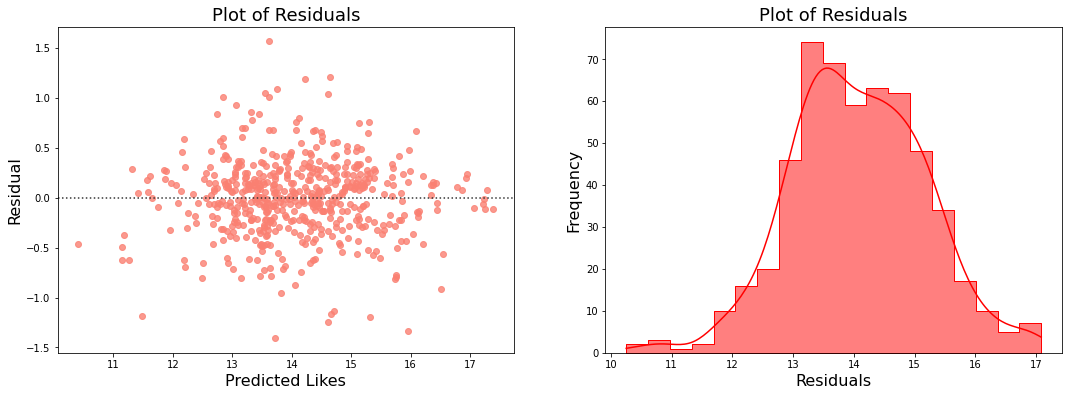

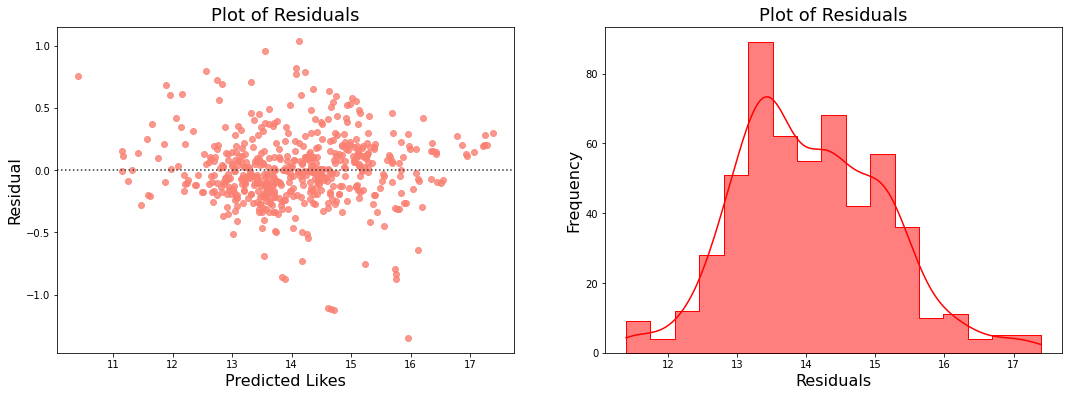

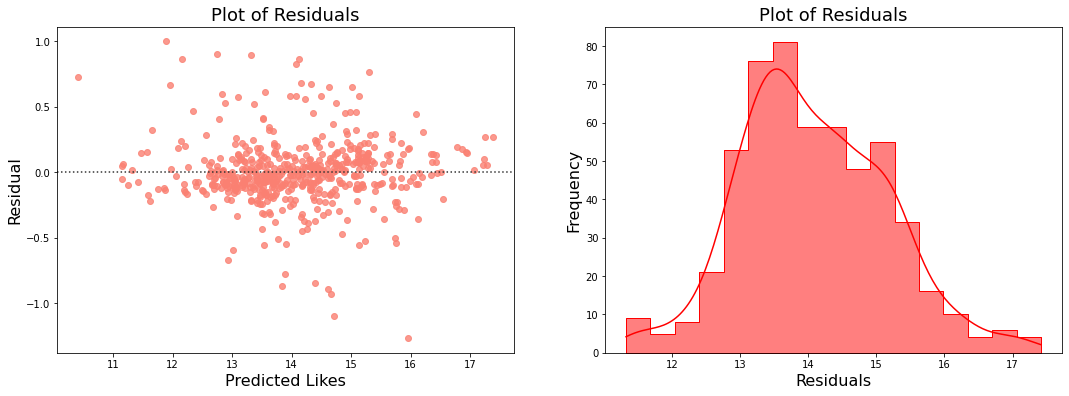

In [19]:
regressors = [
        LinearRegression(),
        RandomForestRegressor(**rfTrial.params),
        xgb.XGBRegressor(**xgbTrial.params),
    ]

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)

    y_pred = pipe.predict(X_test)
    d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}

    print("Model Score: %.3f" % pipe.score(X_test, y_test))
    mae = metrics.mean_absolute_error(y_test, pipe.predict(X_test))
    mse = metrics.mean_squared_error(y_test,pipe.predict(X_test))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pipe.predict(X_test)))
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse: ", rmse, "\n")

    data = pd.DataFrame(data = d1)
    # Residual Plot 1
    fig1, ax1 = plt.subplots(1,2, figsize=(18,6))
    g1 = sns.residplot(x= y_test, y= y_pred, ax=ax1[0], data = data, color="salmon")
    g1.set_xlabel('Predicted Likes', fontsize=16)
    g1.set_ylabel('Residual', fontsize=16)
    g1.set_title("Plot of Residuals", fontsize=18)

    # Residual Plot 2
    g2 = sns.histplot(x=y_pred, ax=ax1[1], data = data, element="step", color="red", kde=True)
    g2.set_xlabel('Residuals', fontsize=16)
    g2.set_ylabel('Frequency', fontsize=16)
    g2.set_title("Plot of Residuals", fontsize=18)
    
    # Linear Plot
    # lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = data, size = 10)
    # fig1 = lm1.fig 
    # fig1.suptitle("Sklearn ", fontsize=18)
    # sns.set(font_scale = 1.5)

#### 3.2.4 Random Forest Regressor

In [20]:
reg = RandomForestRegressor(**rfTrial.params, oob_score=True)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('regressor', reg)])
pipe.fit(X_train, y_train)   
print(reg)

print("Model Train Score: %.3f" % pipe.score(X_train, y_train))
print("Model OOB Score: %.3f" % reg.oob_score_)
print("Model Test Score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor(max_depth=48, n_estimators=471, oob_score=True)
Model Train Score: 0.990
Model OOB Score: 0.924
Model Test Score: 0.933


##### 3.2.4.1 Feature Importance

In [21]:
pd.DataFrame(zip(X.columns,reg.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)


,feature,importance
2,likes_log,0.669997
1,likeRatio,0.192503
3,dislikes_log,0.016953
5,days_lapse,0.015625
0,categoryId,0.014398
6,durationHr,0.013727
4,comment_log,0.010370
9,titleLength,0.000469
7,durationMin,0.000319
8,durationSec,0.000189


#### 3.2.5 Views Evaluation

In [22]:
eval = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb.XGBRegressor(**xgbTrial.params))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

mae = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print("mae: ", mae)
print("mse: ", mse)
print("rmse: ", rmse)
print("r2: ", r2)

mae:  0.20268091113761658
mse:  0.08681985122882933
rmse:  0.2946520850576648
r2:  0.9327167944503859


In [23]:
df = pd.DataFrame(data=list(zip(list(y_test), list(y_pred))),columns=['actual','predicted'])

#Unlog Values
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.e**x)

df

,actual,predicted
0,1138317.0,1.548833e+06
1,6466733.0,6.173139e+06
2,3670365.0,3.750036e+06
3,10925330.0,1.373437e+07
4,10835047.0,6.972052e+06
...,...,...
543,2366855.0,2.172156e+06
544,1020321.0,7.695847e+05
545,902733.0,5.452046e+05
546,696658.0,5.297252e+05
